table of contents
1. 準備
2. データのインポート
3. パスラインの可視化

# 準備

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

# データのインポート

In [2]:
base_dir = os.path.join('..','..')
data_dir = os.path.join(base_dir, 'data', 'raw')

def read_dfs():
    players_df = pd.read_json(os.path.join(data_dir, 'players.json'))
    teams_df = pd.read_json(os.path.join(data_dir, 'teams.json'))

    # encode, decode
    players_df['shortName'] = players_df.shortName.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    teams_df['name'] = teams_df.name.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    return players_df, teams_df

players_df, teams_df = read_dfs()

competition_list = [infile.replace('matches_','').replace('.json','') for infile in os.listdir(os.path.join(data_dir, 'matches')) if infile.endswith('.json')]

print(competition_list)

['World_Cup', 'Italy', 'Germany', 'England', 'France', 'Spain', 'European_Championship']


In [3]:
selected_competition = 'European_Championship'

def read_events_df(selected_competition):
    events_df = pd.read_json(os.path.join(data_dir, 'events', f'events_{selected_competition}.json'))
    return events_df

def read_matches_df(selected_competition):
    matches_df = pd.read_json(os.path.join(data_dir, 'matches', f'matches_{selected_competition}.json'))
    matches_df['date_time'] = pd.to_datetime(matches_df.dateutc)

    # encode, decode
    matches_df['label'] = matches_df.label.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    matches_df['venue'] = matches_df.venue.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    # concate label, venue, date_time
    matches_df['name'] = matches_df[['label', 'venue', 'date_time']].apply(lambda xs: f'{xs[0]} @{xs[1]}, {xs[2].date()}', axis=1)

    return matches_df.sort_values('date_time')

matches_df = read_matches_df(selected_competition)

name_list = matches_df.name.tolist()
print(name_list)

['France - Romania, 2 - 1 @Stade de France, 2016-06-10', 'Albania - Switzerland, 0 - 1 @Stade Bollaert-Delelis, 2016-06-11', 'Wales - Slovakia, 2 - 1 @Stade Matmut-Atlantique, 2016-06-11', 'England - Russia, 1 - 1 @Stade Vélodrome, 2016-06-11', 'Turkey - Croatia, 0 - 1 @Parc des Princes, 2016-06-12', 'Poland - Northern Ireland, 1 - 0 @Allianz Riviera, 2016-06-12', 'Germany - Ukraine, 2 - 0 @Stade Pierre-Mauroy, 2016-06-12', 'Spain - Czech Republic, 1 - 0 @Stadium Municipal, 2016-06-13', 'Republic of Ireland - Sweden, 1 - 1 @Stade de France, 2016-06-13', 'Belgium - Italy, 0 - 2 @Groupama Stadium, 2016-06-13', 'Austria - Hungary, 0 - 2 @Stade Matmut-Atlantique, 2016-06-14', 'Portugal - Iceland, 1 - 1 @Stade Geoffroy-Guichard, 2016-06-14', 'Russia - Slovakia, 1 - 2 @Stade Pierre-Mauroy, 2016-06-15', 'Romania - Switzerland, 1 - 1 @Parc des Princes, 2016-06-15', 'France - Albania, 2 - 0 @Stade Vélodrome, 2016-06-15', 'England - Wales, 2 - 1 @Stade Bollaert-Delelis, 2016-06-16', 'Ukraine - N

In [4]:
selected_match = 'Germany - France, 0 - 2 @Stade Vélodrome, 2016-07-07'
selected_wyId = matches_df[matches_df.name == selected_match].wyId.values[0]

events_df = read_events_df(selected_competition)

matchPeriod_list = ['1H', '2H']

df_tmp = events_df[(events_df.matchId == selected_wyId)&(events_df.eventName=='Pass')&(events_df.matchPeriod.isin(matchPeriod_list))]

# パスラインの可視化

## 関数の定義

In [5]:
from plotly.subplots import make_subplots

def draw_pitches(nrows, ncols, title_list=[], colorbar=False):

    COLOR = 'white'
    twitter_color = 'rgb(20,29,38)'

    fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=title_list, horizontal_spacing=0.05, vertical_spacing=0.05)
    for i in range(1,nrows+1):
        for j in range(1,ncols+1):
            
            line_list = [[[0,120], [0,0]], [[120,120], [0,80]], [[120,0], [80,80]], [[0,0], [80,0]], [[60,60], [0,80]]]
            line_list += [[[0,18], [18,18]], [[18,18], [18,62]], [[18,0], [62,62]], [[0,6], [30,30]], [[6,6], [30,50]], [[6,0], [50,50]]]
            line_list += [[[120, 102], [18,18]], [[102,102], [18,62]], [[102,120], [62,62]], [[120,114], [30,30]], [[114,114], [30,50]], [[114,120], [50,50]]]

            for [x, y] in line_list:
                fig.add_trace(go.Scatter(x=x, y=y,
                                    mode='lines',
                                    line=dict(color=COLOR, width=2.5),
                                    showlegend=False,
                                    hoverinfo='none'
                                    )
                             , row=i, col=j)

            line_list = [[[0,0], [36,44]], [[120,120], [36,44]]]
            for [x, y] in line_list:
                fig.add_trace(go.Scatter(x=x, y=y,
                                    mode='lines',
                                    line=dict(color=COLOR, width=12.5),
                                    showlegend=False,
                                    hoverinfo='none'
                                    )
                             , row=i, col=j)

            fig.add_shape(go.layout.Shape(type='circle', x0=60-12, y0=40-12, x1=60+12, y1=40+12, line_color=COLOR, line_width=2.5), row=i, col=j)
            fig.update_xaxes(range=[-1, 120+1], visible=False, row=i, col=j)
            fig.update_yaxes(range=[-1, 80+1], visible=False, row=i, col=j)
    
    fig.update_layout(go.Layout(width=120*10, height=80*10, plot_bgcolor=twitter_color, paper_bgcolor=twitter_color, autosize=True, margin=dict(l=10, r=10, t=20, b=10), legend=dict(font=dict(color=COLOR))))
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=15,color=COLOR)
    
    return fig

## 可視化

In [7]:
XMAX, XMIN = 120, 0
YMAX, YMIN = 80, 0

df_tmp['st_x'] = None
df_tmp['st_y'] = None
df_tmp['ed_x'] = None
df_tmp['ed_y'] = None

df_tmp[['st_x', 'st_y', 'ed_x', 'ed_y']] = df_tmp.apply(lambda xs: [XMAX*xs['positions'][0]['x']/100, YMAX*(1-xs['positions'][0]['y']/100), XMAX*xs['positions'][1]['x']/100, YMAX*(1-xs['positions'][1]['y']/100)], result_type='expand', axis=1)

df_tmp['result'] = df_tmp.apply(lambda xs: 'success' if 1801 in [tag['id'] for tag in xs['tags']] else 'failure', axis=1)
df_tmp['name'] = df_tmp.apply(lambda xs: 'player= '+players_df[players_df.wyId==xs['playerId']].shortName.tolist()[0]+'\n time= '+str(int(xs['eventSec']/60))+'m'+str(int(xs['eventSec']%60))+'s\n subEventName= '+xs['subEventName']+'\n result= '+xs['result'], axis=1)

/Users/yamamuros83/.pyenv/versions/anaconda3-5.3.1/envs/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/yamamuros83/.pyenv/versions/anaconda3-5.3.1/envs/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/yamamuros83/.pyenv/versions/anaconda3-5.3.1/envs/sample_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
T

In [8]:
df_tmp.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,st_x,st_y,ed_x,ed_y,result,name
74554,8,Pass,1.908619,90356461,1694439,1H,25397,"[{'y': 33, 'x': 28}, {'y': 73, 'x': 29}]",85,Simple pass,[{'id': 1801}],4418,33.6,53.6,34.8,21.6,success,player= S. Umtiti\n time= 0m1s\n subEventName=...
74555,8,Pass,5.177858,90356462,1694439,1H,7855,"[{'y': 73, 'x': 29}, {'y': 73, 'x': 32}]",85,Simple pass,[{'id': 1801}],4418,34.8,21.6,38.4,21.6,success,player= L. Koscielny\n time= 0m5s\n subEventNa...
74556,8,Pass,7.405928,90356463,1694439,1H,7936,"[{'y': 73, 'x': 32}, {'y': 80, 'x': 26}]",85,Simple pass,[{'id': 1801}],4418,38.4,21.6,31.2,16.0,success,player= P. Pogba\n time= 0m7s\n subEventName= ...
74557,8,Pass,11.910527,90356464,1694439,1H,7855,"[{'y': 80, 'x': 26}, {'y': 80, 'x': 64}]",83,High pass,[{'id': 1801}],4418,31.2,16.0,76.8,16.0,success,player= L. Koscielny\n time= 0m11s\n subEventN...
74560,8,Pass,16.324747,90356471,1694439,1H,14716,"[{'y': 40, 'x': 25}, {'y': 37, 'x': 4}]",85,Simple pass,[{'id': 1801}],3148,30.0,48.0,4.8,50.4,success,player= J. Boateng\n time= 0m16s\n subEventNam...


In [66]:
subEventName_list = df_tmp.subEventName.unique().tolist()
legend_dict = dict(zip(subEventName_list, [0]*len(subEventName_list)))
color_list = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']
color_dict = dict(zip(subEventName_list, color_list[:len(subEventName_list)]))

In [92]:
title_list = [f'{matchPeriod} {teams_df[teams_df.wyId==teamId].name.values[0]}' for [matchPeriod, teamId] in df_tmp[['matchPeriod', 'teamId']].drop_duplicates().sort_values(by=['teamId', 'matchPeriod']).values.tolist()]
fig = draw_pitches(2, 2, title_list)

In [93]:
from tqdm import tqdm
for i, (matchPeriod, teamId) in enumerate(df_tmp[['matchPeriod', 'teamId']].drop_duplicates().sort_values(by=['teamId', 'matchPeriod']).values.tolist()):
    i += 1
    for (st_x, st_y, ed_x, ed_y, subEventName, result, name) in df_tmp[(df_tmp.matchPeriod==matchPeriod)&(df_tmp.teamId==teamId)][['st_x', 'st_y', 'ed_x', 'ed_y', 'subEventName', 'result', 'name']].values.tolist():
        fig.add_annotation(go.layout.Annotation(
            captureevents=True,
            hovertext=name,
            x=ed_x,
            y=ed_y,
            xref=f'x{i}',
            yref=f'y{i}',
            axref=f'x{i}',
            ayref=f'y{i}',
            ax=st_x,
            ay=st_y,
            arrowhead=4,
            arrowsize=2,
            arrowcolor=color_dict[subEventName],
            showarrow=True,
#             showlegend=legend_dict[subEventName] == 0
        ))
    break
    legend_dict[subEventName] += 1

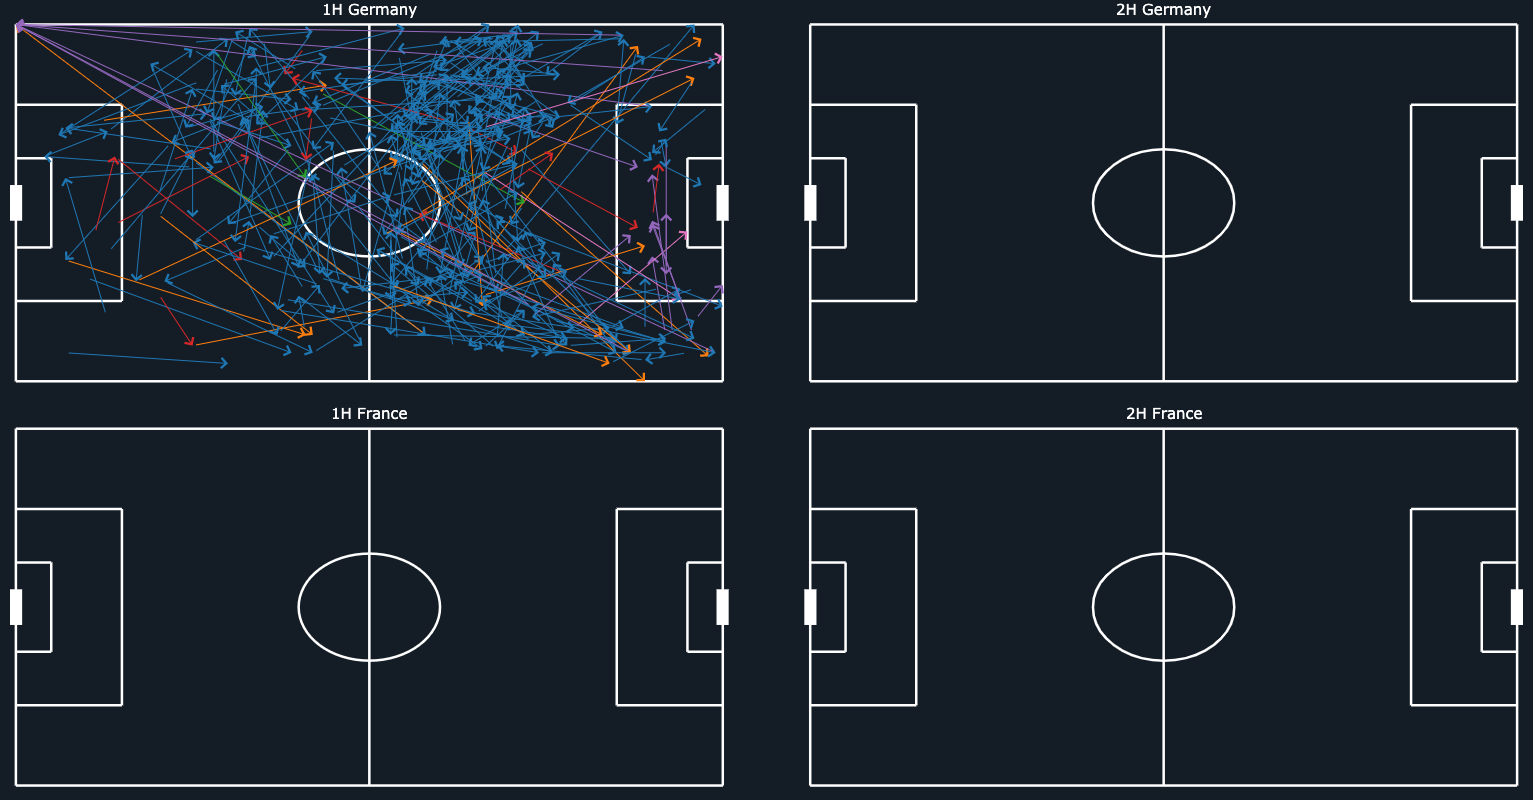

In [94]:
fig.show()